# Web Scraping 

In [4]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

######1. Web Scraping all the tables about of the wiki page

#Make a request to the webpage
url = 'https://en.wikipedia.org/wiki/Legality_of_cryptocurrency_by_country_or_territory'
response = requests.get(url)
#Parse the HTML content
soup = BeautifulSoup(response.content, 'html.parser')
#Find all the tables in the webpage
tables = soup.find_all('table', {'class': 'wikitable'})
#Initialize an empty list to store the data
data = []
#Iterate through the tables
for table in tables:
    #Iterate through the rows of the table
    for row in table.find_all('tr'):
        cells = row.find_all('td')
        if len(cells) > 0:
            #Extract the information from each cell
            country = cells[0].text.strip()
            status = cells[1].text.strip()
            #Split the legal status by '\n'
            status_list = status.split('\n')
            legal_status = status_list[0]
            remaining_text = " ".join(status_list[1:])
            data.append([country, legal_status, remaining_text])
#Create a pandas DataFrame from the list
df = pd.DataFrame(data, columns=['Country', 'Legal Status','Remaining Text'])

#Get the reference number in the remaining text
from weakref import ref
import re
reference_number = []
#Get the reference number in the remaining text
for i in range(len(df)):
  num  = ' '.join(set(re.findall(r"\[(\d+)\]",df['Remaining Text'][i])))
  reference_number.append(num)
df['Reference number'] = reference_number
#Reset the index
df1 = df.set_index(['Country', 'Legal Status','Remaining Text']).apply(lambda x: x.str.split(' ').explode()).reset_index()

#Web scraping the citation number, citation link, and citation date
ref_section = soup.find_all("ol", class_="references")
references = ref_section[1].find_all('li')
#Save the reference id and reference link
id = []
links = []
dates = []
for i in range(0,len(references)):
  id.append(references[i].get('id')) # Get the citation id
  text = references[i].text
  ref_dates = []
  #Get the citation date
  date_match = re.findall(r'(?P<day>\d+)\s+(?P<month>\w+)\s+(?P<year>\d{4})', text)
  if date_match:
    for match in date_match:
        day = match[0]
        month = match[1]
        year = match[2]
        ref_dates.append(f"{day} {month} {year}")
  else:
    date_match = re.findall(r'(?P<month>\w+)\s+(?P<year>\d{4})', text)
    if date_match:
        for match in date_match:
            month = match[0]
            year = match[1]
            ref_dates.append(f"{month} {year}")
  if len(ref_dates) > 0:
    dates.append(ref_dates)
  else:
    year_match = re.findall(r'\b(\d{4})\b', text)
    if year_match:
        dates.append([year_match[0]])
    else:
        dates.append("NA") 
  try:
    links.append(references[i].find_all("a", class_="external text")[0].get('href')) # Get the citation link when class is external text
  except:
    links.append(references[i].find_all("a", class_="external free")[0].get('href')) # Get the citation link when class is external free
#Create a DataFrame from the list
df2 = pd.DataFrame({'Citation Id':id, 'Citation Link':links, 'Citation Date':dates })
#Get the citation number
citation_number = []
for i in range(len(df2)):
  id = re.findall(r'\b\d+\b', df2['Citation Id'][i])[-1]
  citation_number.append(id)
df2['Citation number'] = citation_number

#Merged the web scraping dataframe with the reference dataframe
merged = pd.merge(df1, df2, left_on='Reference number', right_on='Citation number', how ="outer")
merged.sort_values(by='Country', ascending=True, inplace=True)
merged.reset_index(drop=True, inplace=True)




######2. Web scraping the article contents

#Web scraping all the article contents
%pip install newspaper3k
#Using newspaper3k to extract the articles of the links
from newspaper import Article
#Article extraction function
def extract_article_contents(url):
    article = Article(url)
    article.download()
    article.parse()
    return article.text
#Append the article contents to the dataframe
article_contents = []
for link in merged['Citation Link']:
    try:
      article_contents.append(extract_article_contents(link))
    except:
      try:
        from newspaper import Config
        user_agent = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'
        config = Config()
        config.browser_user_agent = user_agent 
        article = Article(link, config=config)
        article.download()
        article.parse()
        article_contents.append(article.text)
      except:
        article_contents.append("No Link")

merged['Article Contents'] = article_contents
display(merged)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


,Country,Legal Status,Remaining Text,Reference number,Citation Id,Citation Link,Citation Date,Citation number,Article Contents
0,Afghanistan,Illegal,In August 2022 Taliban banned trading in cryp...,57,cite_note-57,https://www.bloomberg.com/news/articles/2022-0...,[26 August 2022],57,Why did this happen?\n\nPlease make sure your ...
1,Albania,Legal,"On 21 May 2020, Albania passed a new law to r...",152,cite_note-152,https://www.tagesanzeiger.ch/schweizer-boerse-...,[11 June 2021],152,Digitale Währung im Aufwind – Schweizer Börse ...
2,Algeria,Illegal,"According to the ""Journal Officiel"" (28 Decem...",14,cite_note-RCAWJune2018LOC-14,https://www.loc.gov/item/2021687419/,[14 August 2018],14,Publications of the Law Library of Congress ar...
3,Algeria,Illegal,"According to the ""Journal Officiel"" (28 Decem...",13,cite_note-13,https://www.joradp.dz/FTP/jo-francais/2017/F20...,[3 January 2019],13,
4,Angola,Legal,While government officials have advised again...,24,cite_note-24,https://www.youtube.com/watch?v=CxporKEMZY4,[7 January 2020],24,
...,...,...,...,...,...,...,...,...,...
243,Zimbabwe,Unknown,The Reserve Bank Of Zimbabwe has banned the b...,28,cite_note-RCAWNovember2021LOC-28,https://tile.loc.gov/storage-services/service/...,[9 February 2022],28,
244,NaN,NaN,NaN,NaN,cite_note-1,https://papers.ssrn.com/sol3/papers.cfm?abstra...,[25 September 2017],1,18 Pages Posted: 24 Sep 2017 Last revised: 26 ...
245,NaN,NaN,NaN,NaN,cite_note-2,https://medium.com/coinmonks/cryptos-big-legal...,[25 September 2018],2,Crypto’s Biggest Legal Problems\n\nFor good le...
246,NaN,NaN,NaN,NaN,cite_note-155,https://expathub.ge/cryptocurrency-in-georgia/,[28 September 2021],155,With relaxed laws and 0% tax on income from tr...


In [3]:
from newspaper import Config

user_agent = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'
config = Config()
config.browser_user_agent = user_agent 

article = Article('http://www.bcb.gov.br/pre/normativos/busca/normativo.asp?numero=31379&tipo=Comunicado&data=16/11/2017', config=config)
article.download()
article.parse()
article.text

''

In [7]:
from newspaper import Article

url = 'https://www.bloomberg.com/news/articles/2022-08-26/taliban-ban-crypto-in-afghanistan-arrest-digital-coin-dealers'
article = Article(url, request_headers={'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'})

article.download()
article.parse()

if article.text:
    print(article.text)
else:
    print(article.html)


Why did this happen?

Please make sure your browser supports JavaScript and cookies and that you are not blocking them from loading. For more information you can review our Terms of Service and Cookie Policy.


# Translate the article contents

In [ ]:
!pip install googletrans==4.0.0-rc1

from googletrans import Translator

#Create a translator object
translator = Translator()

#Translate all the articles
article_contents_en = []
for article in merged['Article Contents']:
    try:
        article_en = translator.translate(article, dest='en').text
        article_contents_en.append(article_en)
    except:
        article_contents_en.append("Translation Unavailable")
#Add the translated articles to the DataFrame
merged['Article Contents (EN)'] = article_contents_en
display(merged)

# Word Clound


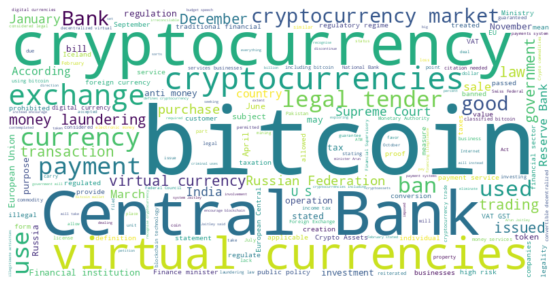

In [15]:
# Import necessary libraries
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Filter the data to include only countries with legal status starting with "Legal"
merged = merged.dropna(subset=["Remaining Text"])

# filter the DataFrame to include only the rows where the legal status starts with "Legal"
legal_countries = merged[merged["Legal Status"].str.startswith("Legal")]

# Join all the remaining text for the selected countries into a single string
text = ' '.join(legal_countries['Remaining Text'])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the WordCloud image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


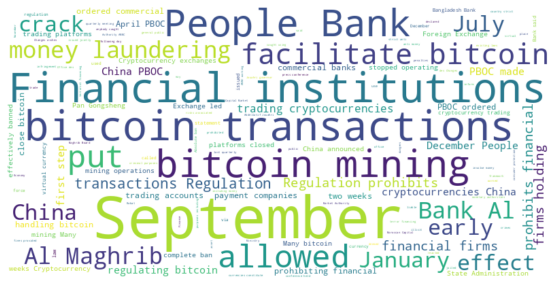

In [16]:
# Import necessary libraries
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Filter the data to include only countries with legal status starting with "Legal"
merged = merged.dropna(subset=["Remaining Text"])

# filter the DataFrame to include only the rows where the legal status starts with "Legal"
legal_countries = merged[merged["Legal Status"]=='Illegal']

# Join all the remaining text for the selected countries into a single string
text = ' '.join(legal_countries['Remaining Text'])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the WordCloud image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

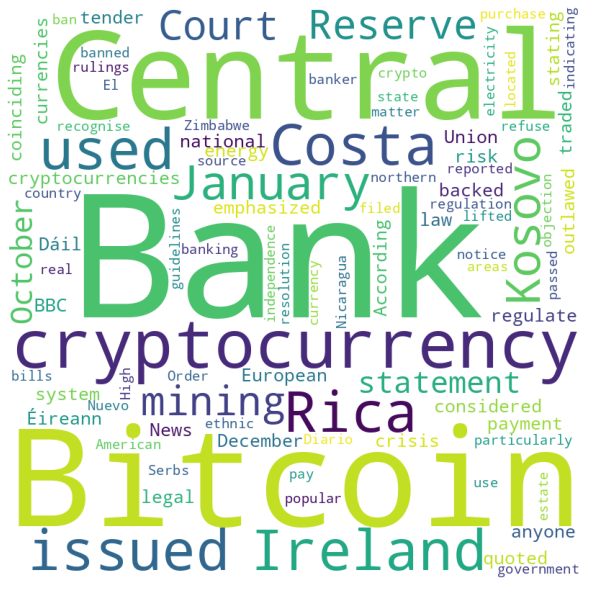

In [17]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt



# Filter for the countries with legal status not starting with "Legal" and not "Illegal"
legal_status_mask = ~merged['Legal Status'].str.startswith('Legal', na=False) & (merged['Legal Status'] != 'Illegal')
remaining_text = merged.loc[legal_status_mask, 'Remaining Text'].dropna()

# Join all remaining text into a single string
text = ' '.join(remaining_text)

# Generate word cloud
wordcloud = WordCloud(width=800, height=800, background_color='white').generate(text)

# Plot the word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()


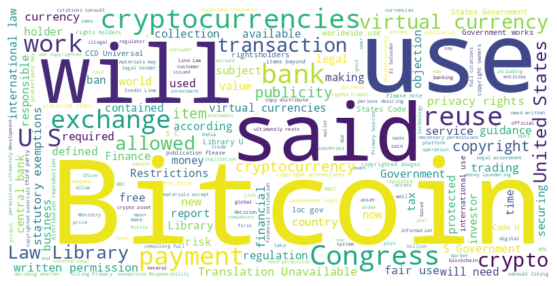

In [20]:
# Import necessary libraries
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Filter the data to include only countries with legal status starting with "Legal"
merged = merged.dropna(subset=['Article Contents (EN)'])

# filter the DataFrame to include only the rows where the legal status starts with "Legal"
legal_countries = merged[merged["Legal Status"].str.startswith("Legal")]

# Join all the remaining text for the selected countries into a single string
text = ' '.join(legal_countries['Article Contents (EN)'])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the WordCloud image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


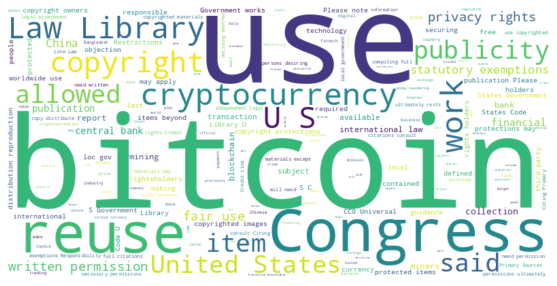

In [21]:
# Import necessary libraries
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Filter the data to include only countries with legal status starting with "Legal"
merged = merged.dropna(subset=['Article Contents (EN)'])

# filter the DataFrame to include only the rows where the legal status starts with "Legal"
legal_countries = merged[merged["Legal Status"]=='Illegal']

# Join all the remaining text for the selected countries into a single string
text = ' '.join(legal_countries['Article Contents (EN)'])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the WordCloud image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

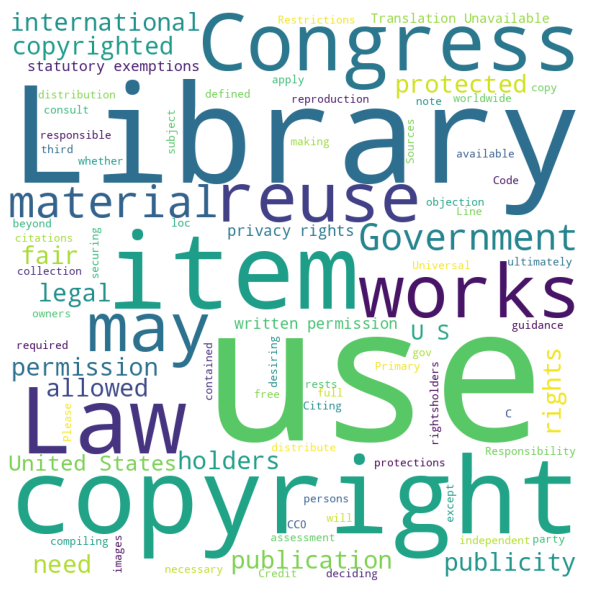

In [22]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt



# Filter for the countries with legal status not starting with "Legal" and not "Illegal"
legal_status_mask = ~merged['Legal Status'].str.startswith('Legal', na=False) & (merged['Legal Status'] != 'Illegal')
remaining_text = merged.loc[legal_status_mask, 'Article Contents (EN)'].dropna()

# Join all remaining text into a single string
text = ' '.join(remaining_text)

# Generate word cloud
wordcloud = WordCloud(width=800, height=800, background_color='white').generate(text)

# Plot the word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

# Topic Modeling

In [ ]:
#Import necessary libraries
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('all')
nltk.download('stopwords')
import pandas as pd
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2022)

In [ ]:
#Pre-process text function
def preprocess(text):
    #Tokenize the text
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    #Remove stopwords
    stopword_list = set(stopwords.words("english"))
    filtered_tokens = [token.lower() for token in tokens if token.lower() not in stopword_list]
    #Lemmatize the filtered tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    #Return the lemmatized tokens as a string
    return " ".join(lemmatized_tokens)

In [ ]:
#Check if any row in "Remaining Text" column contains NaN values
if merged["Remaining Text"].isnull().sum() > 0:
    #Drop rows with NaN values in "Remaining Text" column
    merged.dropna(subset=["Remaining Text"], inplace=True)

#Preprocess the text data in "Remaining Text" column
processed_docs1 = merged["Remaining Text"].apply(preprocess)

#Convert processed_docs to a list of lists:
processed_docs1 = [doc1.split() for doc1 in processed_docs1]

#Build a dictionary representation of the documents
dictionary1 = gensim.corpora.Dictionary(processed_docs1)
#Filter out the extremes (similar to the min/max df step used when creating the TF-IDF matrix)
dictionary1.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
#Bag-of-words representation of the documents
bow_corpus1 = [dictionary1.doc2bow(doc1) for doc1 in processed_docs1]

#Train a LDA model
num_topics = 10
lda_model1 = gensim.models.LdaMulticore(bow_corpus1, num_topics=num_topics, id2word=dictionary1)

#Get the most dominant topic for each row
topic_weights1 = []
for row1 in lda_model1[bow_corpus1]:
    row_weights1 = [w1[1] for w1 in row1]
    topic_weights1.append(row_weights1)

dominant_topic1 = [np.argmax(weights1) for weights1 in topic_weights1]

#Get the topic words for each dominant topic
topic_words1 = []
for topic_id1 in range(num_topics):
    top_words1 = [(word1, prob1) for word1, prob1 in lda_model1.show_topic(topic_id1, topn=10)]
    topic_words1.append(top_words1)

#Reset the indices of the DataFrame
merged.reset_index(inplace=True, drop=True)

#Append the dominant topic and topic words to the DataFrame
merged["Dominant_Topic"] = dominant_topic1
merged["Topic_Words"] = [topic_words1[idx1] for idx1 in dominant_topic1]

#Print the DataFrame with the new columns
display(merged)

In [ ]:
#Check if any row in "Article Contents" column contains NaN values
if merged["Article Contents (EN)"].isnull().sum() > 0:
    #Drop rows with NaN values in "Article Contents" column
    merged.dropna(subset=["Article Contents (EN)"], inplace=True)

#Preprocess the text data in "Article Contents" column
processed_docs2 = merged["Article Contents (EN)"].apply(preprocess)

#Convert processed_docs to a list of lists:
processed_docs2 = [doc2.split() for doc2 in processed_docs2]

#Build a dictionary representation of the documents
dictionary2 = gensim.corpora.Dictionary(processed_docs2)
#Filter out the extremes (similar to the min/max df step used when creating the TF-IDF matrix)
dictionary2.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
#Bag-of-words representation of the documents
bow_corpus2 = [dictionary2.doc2bow(doc2) for doc2 in processed_docs2]

#Train a LDA model
num_topics = 10
lda_model2 = gensim.models.LdaMulticore(bow_corpus2, num_topics=num_topics, id2word=dictionary2)

#Get the most dominant topic for each row
topic_weights2 = []
for row2 in lda_model2[bow_corpus2]:
    row_weights2 = [w2[1] for w2 in row2]
    topic_weights2.append(row_weights2)

dominant_topic2 = [np.argmax(weights2) for weights2 in topic_weights2]

#Get the topic words for each dominant topic
topic_words2 = []
for topic_id2 in range(num_topics):
    top_words2 = [(word2, prob2) for word2, prob2 in lda_model2.show_topic(topic_id2, topn=10)]
    topic_words2.append(top_words2)

#Reset the indices of the DataFrame
merged.reset_index(inplace=True, drop=True)

#Append the dominant topic and topic words to the DataFrame
merged["Dominant_Topic2"] = dominant_topic2
merged["Topic_Words2"] = [topic_words2[idx2] for idx2 in dominant_topic2]

#Print the DataFrame with the new columns
display(merged)

merged.to_csv(r'C:\Users\wuxiong\Downloads\research.csv')